In [ ]:
# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries for data manipulation, machine learning, and model building
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Paths to your dataset in Google Drive
train_data_path = '/content/drive/My Drive/archive/train.csv'
test_data_path = '/content/drive/My Drive/archive/test.csv'

# Load the UCI HAR dataset into pandas DataFrames
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [ ]:
# Display basic information about the datasets
print("Train Data Info:")
print(train_data.info())
print("Test Data Info:")
print(test_data.info())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB
None


In [ ]:
# Split the features (X) and labels (y) in both training and testing datasets
X_train = train_data.drop(columns=['Activity'])
y_train = train_data['Activity']
X_test = test_data.drop(columns=['Activity'])
y_test = test_data['Activity']

In [ ]:
# Map activities to numerical labels (encoding the activity names)
activity_mapping = {
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 2,
    'WALKING_DOWNSTAIRS': 3,
    'SITTING': 4,
    'STANDING': 5
}

In [ ]:
# Apply the mapping to convert the activity labels into numerical form
y_train = y_train.map(activity_mapping)
y_test = y_test.map(activity_mapping)

# Convert labels to categorical format (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes=6)
y_test = keras.utils.to_categorical(y_test, num_classes=6)

In [ ]:
# Define the number of timesteps (time steps per sample)
timesteps = 10  # Can adjust based on the nature of data

# Calculate the number of features per timestep
total_features = X_train.shape[1]
features_per_timestep = total_features // timesteps

In [ ]:
# Trim any excess columns if necessary to fit the timesteps
X_train_trimmed = X_train.values[:, :features_per_timestep * timesteps]
X_test_trimmed = X_test.values[:, :features_per_timestep * timesteps]

In [ ]:
# Reshape the data for CNN-LSTM input (samples, timesteps, features per timestep)
X_train_cnn_lstm = X_train_trimmed.reshape(-1, timesteps, features_per_timestep)
X_test_cnn_lstm = X_test_trimmed.reshape(-1, timesteps, features_per_timestep)

In [ ]:
# Setup Stratified K-Fold Cross-Validation with 3 folds
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Placeholder arrays for predictions and model performance metrics
valid_preds = np.zeros((X_train_cnn_lstm.shape[0], 6))
test_preds = np.zeros((n_splits, X_test_cnn_lstm.shape[0], 6))

In [ ]:
# Track loss and accuracy per fold
train_loss_per_fold = []
val_loss_per_fold = []
train_acc_per_fold = []
val_acc_per_fold = []

In [ ]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

# Initialize variables for tracking the best fold
best_val_acc = 0
best_fold_id = -1
best_fold_predictions = None

In [ ]:
# Iterate through each fold in the Stratified K-Fold Cross-Validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, np.argmax(y_train, axis=1))):
    # Split data into training and validation sets for the current fold
    X_tr = X_train_cnn_lstm[train_index]
    X_val = X_train_cnn_lstm[valid_index]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    print(f"Fold {fold_id}: X_tr shape: {X_tr.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test_cnn_lstm.shape}")

    # Build a CNN-LSTM hybrid model
    model = keras.Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, features_per_timestep)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.5),
        LSTM(32, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(6, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model on the current training fold
    history = model.fit(X_tr, y_tr, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1,
                        callbacks=[early_stopping, reduce_lr])

    # Store the performance metrics for each fold
    train_loss_per_fold.append(history.history['loss'])
    val_loss_per_fold.append(history.history['val_loss'])
    train_acc_per_fold.append(history.history['accuracy'])
    val_acc_per_fold.append(history.history['val_accuracy'])

    # Make predictions on validation set and the test set
    val_preds = model.predict(X_val)
    valid_preds[valid_index] = val_preds
    test_preds[fold_id] = model.predict(X_test_cnn_lstm)

    # Evaluate validation accuracy and track the best fold
    val_pred_classes = val_preds.argmax(axis=1)
    y_val_classes = y_val.argmax(axis=1)
    val_accuracy = accuracy_score(y_val_classes, val_pred_classes)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_fold_id = fold_id
        best_fold_predictions = val_preds
        best_y_val_classes = y_val_classes


Fold 0: X_tr shape: (4901, 10, 56), X_val shape: (2451, 10, 56), X_test shape: (2947, 10, 56)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.2454 - loss: 1.6745 - val_accuracy: 0.3839 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4363 - loss: 1.1978 - val_accuracy: 0.7303 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6362 - loss: 0.7769 - val_accuracy: 0.8470 - val_loss: 0.4202 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7326 - loss: 0.5666 - val_accuracy: 0.8311 - val_loss: 0.2778 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8107 - loss: 0.4393 - val_accuracy: 0.9217 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8548 - loss: 0.3525 - val_accuracy: 0.9094 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8668 - loss: 0.3513 - val_accuracy: 0.92

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2274 - loss: 1.7088 - val_accuracy: 0.4480 - val_loss: 1.1374 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4272 - loss: 1.1974 - val_accuracy: 0.6699 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6155 - loss: 0.7854 - val_accuracy: 0.7862 - val_loss: 0.5018 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6791 - loss: 0.6345 - val_accuracy: 0.8727 - val_loss: 0.3836 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7861 - loss: 0.4898 - val_accuracy: 0.8919 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8261 - loss: 0.4108 - val_accuracy: 0.9164 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8585 - loss: 0.3495 - val_accuracy: 0.9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.2454 - loss: 1.6472 - val_accuracy: 0.3629 - val_loss: 1.1208 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4420 - loss: 1.1799 - val_accuracy: 0.7155 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6585 - loss: 0.7499 - val_accuracy: 0.8335 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7595 - loss: 0.5571 - val_accuracy: 0.8869 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8226 - loss: 0.4147 - val_accuracy: 0.9192 - val_loss: 0.2442 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8425 - loss: 0.3819 - val_accuracy: 0.9224 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8738 - loss: 0.3303 - val_accuracy: 0.9

In [ ]:
# Print the classification report for the best fold
print("Classification Report for the Best Fold:")
best_fold_pred_classes = best_fold_predictions.argmax(axis=1)
print(classification_report(best_y_val_classes, best_fold_pred_classes, target_names=activity_mapping.keys()))

Classification Report for the Best Fold:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       469
           WALKING       1.00      1.00      1.00       409
  WALKING_UPSTAIRS       1.00      0.99      1.00       358
WALKING_DOWNSTAIRS       1.00      1.00      1.00       328
           SITTING       0.96      0.95      0.95       429
          STANDING       0.96      0.96      0.96       458

          accuracy                           0.98      2451
         macro avg       0.98      0.98      0.98      2451
      weighted avg       0.98      0.98      0.98      2451



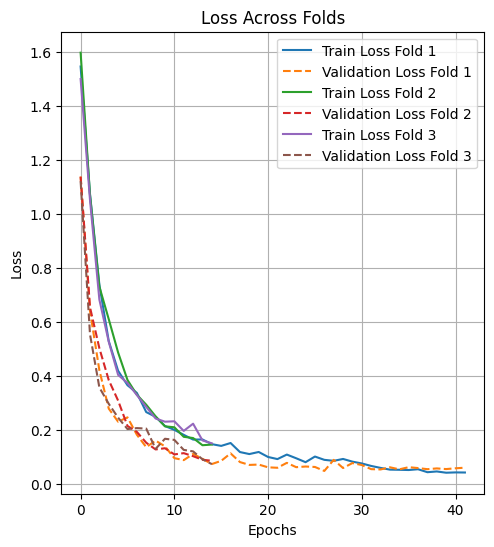

In [ ]:
# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 6))

# Loss Curve
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(train_loss_per_fold[i], label=f'Train Loss Fold {i+1}')
    plt.plot(val_loss_per_fold[i], label=f'Validation Loss Fold {i+1}', linestyle='--')
plt.title('Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

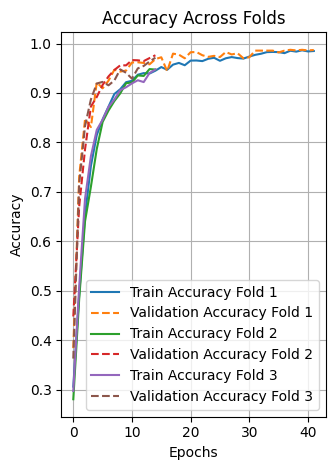

In [ ]:
# Accuracy Curve
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(train_acc_per_fold[i], label=f'Train Accuracy Fold {i+1}')
    plt.plot(val_acc_per_fold[i], label=f'Validation Accuracy Fold {i+1}', linestyle='--')
plt.title('Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Averaging predictions across folds for test set
test_predictions = test_preds.mean(axis=0)
test_pred_classes = test_predictions.argmax(axis=1)

In [ ]:
# Print test accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report for the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test.argmax(axis=1), test_pred_classes, target_names=activity_mapping.keys()))

Test Accuracy: 0.9481

Classification Report on Test Set:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           WALKING       0.95      0.97      0.96       496
  WALKING_UPSTAIRS       0.94      0.94      0.94       471
WALKING_DOWNSTAIRS       0.96      0.94      0.95       420
           SITTING       0.94      0.87      0.91       491
          STANDING       0.90      0.95      0.92       532

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



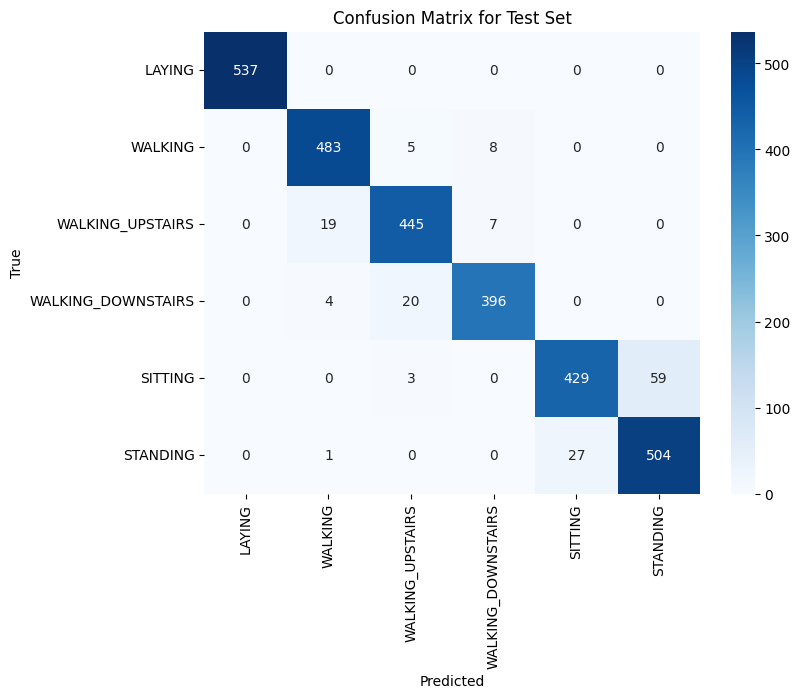

In [ ]:
# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_test.argmax(axis=1), test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.keys(), yticklabels=activity_mapping.keys())
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()